# Contextualized GAMs

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import sys
print(sys.version_info)
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import f1_score

from contextualized.easy import ContextualGAMClassifier

sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)


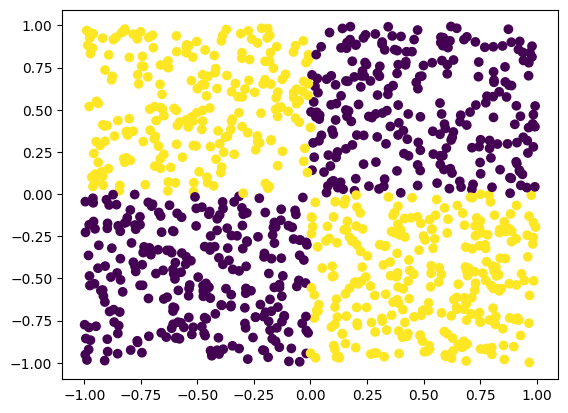

In [2]:
X = np.random.uniform(-1, 1, size=(1000, 2))
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
plt.scatter(X[:, 0], X[:, 1], c=Y)

col_names = [i for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=col_names)
Y = pd.DataFrame(Y).astype(int)
# Model can handle either regression or classification, but plotting currently implemented for classification.

In [3]:
contextual_feats = col_names
explainable_feats = []
for feat in contextual_feats:
    explainable_name = "{} Elev.".format(feat)
    X[explainable_name] = X[feat] > 0.
    X[explainable_name] = X[explainable_name].astype(int)
    explainable_feats.append(explainable_name)

contextual = X[contextual_feats].copy()
explainable = X[explainable_feats].copy()

C_train, C_test, X_train, X_test, X_all_train, X_all_test, Y_train, Y_test = train_test_split(
    contextual, explainable, X, Y, test_size=0.25)
X_train.shape, Y_train.shape, C_train.shape

((750, 2), (750, 1), (750, 2))

In [5]:
# Fit Contextualized GAMs.
cgam = ContextualGAMClassifier(num_archetypes=X_train.shape[1], 
                                encoder_kwargs={'width': 4, 'layers': 2},
                               encoder_link_fn='linear',
                                alpha=1e-1, val_split=0.2, learning_rate=1e-3, n_bootstraps=3)
cgam.fit(C_train.values, X_train.values, Y_train.values)

KeyError: 'link_fn'

In [ ]:
train_preds = cgam.predict_proba(C_train.values, X_train.values)[:, 0, 1]
test_preds  = cgam.predict_proba(C_test.values, X_test.values)[:, 0, 1]
results = {
        "cgam": {
            "train": {
                "roc": roc(Y_train, train_preds),
                "f1": f1_score(Y_train, np.round(train_preds))
            },
            "test": {
                "roc": roc(Y_test, test_preds),
                "f1": f1_score(Y_test, np.round(test_preds))
            }}}
print("Train ROC: {:.2f}, F1: {:.2f}".format(results['cgam']['train']['roc'], results['cgam']['train']['f1']))
print("Test ROC: {:.2f}, F1: {:.2f}".format(results['cgam']['test']['roc'], results['cgam']['test']['f1']))

In [ ]:
# Plot Homogeneous (Background effects).
# In this example of XOR interaction, these effects should be 0.
from scContextualized.plot_utils import plot_homogeneous_tx, plot_heterogeneous

plot_homogeneous_tx(cgam.predict_params, C_train, X_train.values, X_train.columns)

In [ ]:
# Plot Heterogeneous (Interactive effects).
# In this example of XOR interaction, the cross-effects (1->0 Elevated) and (0->1 Elevated) are strong.
plot_heterogeneous(cgam.predict_params, C_train, X_train.values, 
                   [], np.zeros((C_train.shape[1])), np.ones((C_train.shape[1])),
                   X_train.columns)